# EDA 1

### Goals

* Initial Exploration of Dataset
* Postpone holidays and oil analysis due to scope for next EDA notebook. Both
are not directly related to the sales.

### Commments

In [516]:
import pandas as pd
import missingno as msno
import seaborn as sns
sns.set_context("talk", font_scale=1.4)
import plotly_express as px

from plotly.subplots import make_subplots
import plotly.graph_objects as go


## TOC:
* [I. Goals](#first-bullet)
* [II. Data Extraction](#second-bullet)
* [III. Meet & Greet](#third-bullet)
* [IV. Univariate Analysis](#fourth-bullet)
* [V. Multivariate Analysis](#fifth-bullet)


# I. Goals  <a class="anchor" id="first-bullet"></a>

Use regression models to predict sales of thousands pf production families sold
at Favoriata Stores in Ecuador.

## Forecasting Scenario

Unclear what the forecasting scenario should be, e.g. forecasting horizon
which would inform the evaluation strategy and the data can be considered as 
features. 
In a scenario if predictions are done at the end of the day for that day
(same-day predictions) all features of that day could
be used as they are available, assuming all features are available at end of day (e.g. oilprice). other
scenarios would have different constraints.

> I assume the same-day predictions described above!

## Evaluation: 

### Train/Test Splits

Test Set construction via split in time. The dates in the test data are for the 15 days after the last date in the training data.


### Metric

RMSLE = $ [\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$

Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.

> is it worse to have more products in stock or to have less products than what
the demand is? Former looses money, latter does not earn money at capacity.
This metric is best to use when targets having exponential growth.

> effect of overprediction


### Domain Transfer

NOte that the transfer of the model to new stores as different domains is questionable
and could be investigated using the existing data, as data has store labels. Note
this is not specified in the goals.

### Product Categories

* HOw well are product categories defined? Is there overlap? Errors or noise?
* No definition is provided

### Sales vs Promotion

* Sales can be float, e.g. 1.5g of X, but onpromotion gives integer values.



In [283]:
from sklearn.metrics import mean_squared_log_error 
import numpy as np
from pathlib import Path

In [284]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

# II. Data Extraction <a class="anchor" id="second-bullet"></a>

Data from some (all?) stores of the Favoriate chain, across a fixed 
time range, spread over multiple files and provided by kaggle.

> Note that the transactions.csv is not described on the Kaggle website
but provided as a file. The containing transactions variable need to 
be used under assumptions to be made.

In [285]:
raw_data_path = Path("../../data/raw/")

In [286]:
! ls $raw_data_path

holidays_events.csv                     stores.csv
oil.csv                                 test.csv
sample_submission.csv                   train.csv
store-sales-time-series-forecasting.zip transactions.csv


In [287]:
! du -h $raw_data_path/*

 24K	../../data/raw/holidays_events.csv
 24K	../../data/raw/oil.csv
336K	../../data/raw/sample_submission.csv
 21M	../../data/raw/store-sales-time-series-forecasting.zip
4.0K	../../data/raw/stores.csv
1.0M	../../data/raw/test.csv
116M	../../data/raw/train.csv
1.5M	../../data/raw/transactions.csv


In [288]:
train = pd.read_csv(raw_data_path/"train.csv", na_values="") 

In [289]:
train.shape

(3000888, 6)

Note train data size as above >1M rows, can justify distributed
computing such as using Dask, PySpark.

In [290]:
test = pd.read_csv(raw_data_path/"test.csv", na_values="")

In [291]:
test.shape

(28512, 5)

In [292]:
stores = pd.read_csv(raw_data_path/"stores.csv", na_values="")

In [293]:
stores.shape

(54, 5)

In [327]:
transactions = pd.read_csv(raw_data_path/"transactions.csv", na_values="")

In [328]:
transactions.shape

(83488, 3)

# III. Meet & Greet  <a class="anchor" id="third-bullet"></a>

Variables:

* store_nbr: identifies the store at which the products are sold.
* family: identifies the type of product sold.
* sales: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). Can be 0!
* onpromotion: gives the total number of items in a product family that were being promoted at a store at a given date.


* city: city of store
* type: type of store, not clear how type is defined.
* cluster: similar to other stores of same type of store. Not clear how cluster
was done, based on which similarity attributes.


* transactions: assume number of transactions. I define a transaction as a single
payment by a customer (can have multiple products sold.)


> data from 54 stores.

In [295]:
train.shape[0]/(train.shape[0] + test.shape[0])

0.9905882352941177

> Odd train-test ratio of just 1% of data being test data for Kaggle
submission.

In [296]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [297]:
train.sample(20, random_state=1)

,id,date,store_nbr,family,sales,onpromotion
1016895,1016895,2014-07-26,41,AUTOMOTIVE,3.000,0
121235,121235,2013-03-10,10,PET SUPPLIES,0.000,0
488669,488669,2013-10-02,20,BREAD/BAKERY,0.000,0
2066791,2066791,2016-03-08,5,BABY CARE,0.000,0
2502014,2502014,2016-11-08,11,LAWN AND GARDEN,1.000,0
197514,197514,2013-04-21,50,DELI,571.485,0
2349454,2349454,2016-08-14,30,LADIESWEAR,1.000,0
2318771,2318771,2016-07-28,2,PET SUPPLIES,5.000,0
2219510,2219510,2016-06-02,34,PREPARED FOODS,31.000,0
1800913,1800913,2015-10-10,4,BOOKS,0.000,0


In [340]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [298]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


> Contrary what is mentioned on the Kaggle site, there is no 15days gap
between train and testset. Both are directly connected without gaps.

* Some categories are little descriptive, e.g. Grocery I, Grocery II.
* Some items are not sold at all, sales = 0

In [299]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [300]:
stores.sample(20, random_state=42)

,store_nbr,city,state,type,cluster
19,20,Quito,Pichincha,B,6
49,50,Ambato,Tungurahua,A,14
48,49,Quito,Pichincha,A,11
12,13,Latacunga,Cotopaxi,C,15
44,45,Quito,Pichincha,A,11
5,6,Quito,Pichincha,D,13
17,18,Quito,Pichincha,B,16
52,53,Manta,Manabi,D,13
3,4,Quito,Pichincha,D,9
32,33,Quevedo,Los Rios,C,3


In [329]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [330]:
transactions.sample(20, random_state=42)

,date,store_nbr,transactions
4387,2013-04-07,17,1500
8131,2013-06-26,41,792
37114,2015-03-06,25,1238
74716,2017-03-05,39,1664
75348,2017-03-17,35,726
22961,2014-05-11,18,1259
15276,2013-11-26,14,1477
81550,2017-07-11,7,1752
52962,2016-01-14,44,3784
45776,2015-08-27,20,1430


In [341]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


## Data Types

In [303]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [304]:
test.dtypes

id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object

In [305]:
train['date'].head().apply(pd.to_datetime)

0   2013-01-01
1   2013-01-01
2   2013-01-01
3   2013-01-01
4   2013-01-01
Name: date, dtype: datetime64[ns]

In [306]:
for df in [train, test]:
    df['date'] = pd.to_datetime(df['date'])

In [307]:
for df in [train, test]:
    df['store_nbr'] = df['store_nbr'].astype(str)
    df['id'] = df['id'].astype(str)

In [308]:
train.dtypes

id                     object
date           datetime64[ns]
store_nbr              object
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [309]:
test.dtypes

id                     object
date           datetime64[ns]
store_nbr              object
family                 object
onpromotion             int64
dtype: object

In [310]:
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

Cluster as type of category to string conversion for now.

In [311]:
stores['cluster'] = stores['cluster'].astype('str')
stores['store_nbr'] = stores['store_nbr'].astype('str')

In [331]:
transactions.dtypes

date            object
store_nbr        int64
transactions     int64
dtype: object

In [346]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['store_nbr'] = transactions['store_nbr'].astype('str')

## Missing Values

Set pandas to only treat "" as missing values. Overall no missing
values of that can find.

In [333]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [315]:
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [316]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [317]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [318]:
stores.shape

(54, 5)

<AxesSubplot:>

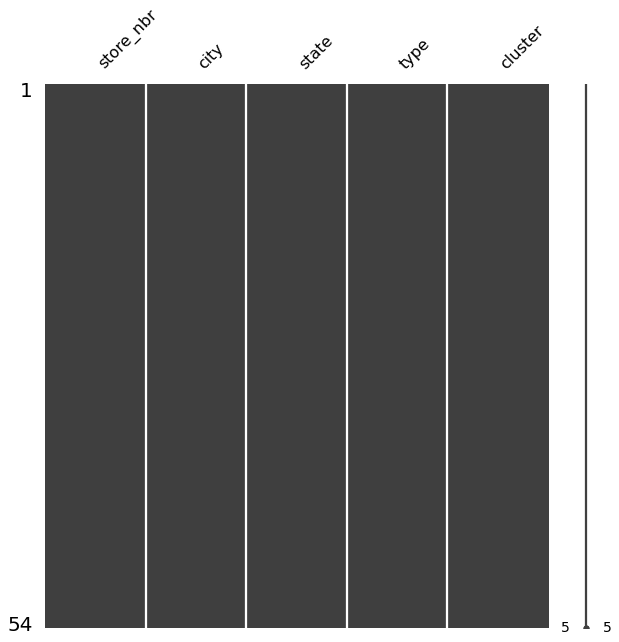

In [319]:
msno.matrix(stores, figsize=(10,10))

> Only the first 5 stores have cluster values. Hence drop the cluster 
variable 

In [320]:
#stores.drop(['cluster'], axis=1, inplace=True)

In [334]:
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

## Duplication

In [ ]:
train.drop_duplicates().shape, train.shape

((3000888, 6), (3000888, 6))

In [ ]:
stores.drop_duplicates().shape, stores.shape

((54, 4), (54, 4))

In [336]:
transactions.drop_duplicates().shape, transactions.shape

((83488, 3), (83488, 3))

# IV. Univariate Distributions  <a class="anchor" id="fourth-bullet"></a>

## General Distributions

In [ ]:
train.describe(percentiles=[0.1, 0.2, 0.4, 0.5, 0.8, 0.9, 0.99]).T

,count,mean,std,min,10%,20%,40%,50%,80%,90%,99%,max
sales,3000888.0,357.775749,1101.997721,0.0,0.0,0.0,3.0,11.0,296.9646,867.0,5507.0,124717.0
onpromotion,3000888.0,2.602770,12.218882,0.0,0.0,0.0,0.0,0.0,1.0000,4.0,55.0,741.0


Daily distributions with strong different among days across all products and stores.

In [ ]:
train.describe(include=['object']).T

,count,unique,top,freq
id,3000888,3000888,0,1
store_nbr,3000888,54,1,55572
family,3000888,33,AUTOMOTIVE,90936


33 different types of products.

Store numbers agree with store.csv.

In [ ]:
stores.describe().T

,count,unique,top,freq
store_nbr,54,54,1,1
city,54,22,Quito,18
state,54,16,Pichincha,19
type,54,5,D,18


> products sold across 22 cities and 16 states


In [347]:
train_extended = pd.merge(train, stores, on='store_nbr', how="left")
train_extended = pd.merge(train_extended, transactions, on=['date', 'store_nbr'], how="left")

In [348]:
train_extended

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0


In [350]:
train_extended.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
transactions    245784
dtype: int64

In [354]:
train_extended.isna().sum()/train_extended.shape[0]

id              0.000000
date            0.000000
store_nbr       0.000000
family          0.000000
sales           0.000000
onpromotion     0.000000
city            0.000000
state           0.000000
type            0.000000
cluster         0.000000
transactions    0.081904
dtype: float64

> For 8% of the store-date combinations we don't have transactions. Worth
investigating in multivariate analysis.

In [356]:
train_extended.describe(percentiles=[0.1, 0.2, 0.4, 0.5, 0.8, 0.9, 0.99]).T

,count,mean,std,min,10%,20%,40%,50%,80%,90%,99%,max
sales,3000888.0,357.775749,1101.997721,0.0,0.0,0.0,3.0,11.0,296.9646,867.0,5507.0,124717.0
onpromotion,3000888.0,2.602770,12.218882,0.0,0.0,0.0,0.0,0.0,1.0000,4.0,55.0,741.0
transactions,2755104.0,1694.602158,963.281049,5.0,754.0,961.0,1260.0,1393.0,2342.0000,3071.0,4862.0,8359.0


## Date 

<AxesSubplot:>

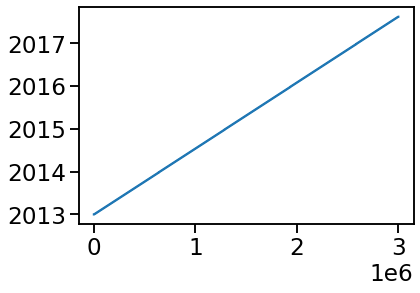

In [ ]:
train_extended['date'].plot()

<AxesSubplot:xlabel='date'>

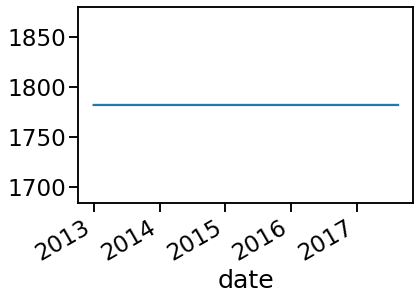

In [ ]:
train_extended.groupby("date").count()['id'].plot()

In [ ]:
train_extended.groupby("date").count()['id'].head()

date
2013-01-01    1782
2013-01-02    1782
2013-01-03    1782
2013-01-04    1782
2013-01-05    1782
Name: id, dtype: int64

each day has the same number of product families, across stores. Expected
as some stores have sales for products of 0.


In [ ]:
train_extended['date'].describe(datetime_is_numeric=True).to_frame().T

,count,mean,min,25%,50%,75%,max
date,3000888,2015-04-24 08:27:04.703088384,2013-01-01,2014-02-26 18:00:00,2015-04-24 12:00:00,2016-06-19 06:00:00,2017-08-15


From 2013 to 2017-08-15, 4 years 8months and 15 days of data, which
could include yearly seasonal affects 

In [357]:
test['date'].describe(datetime_is_numeric=True).to_frame().T

,count,mean,min,25%,50%,75%,max
date,28512,2017-08-23 12:00:00,2017-08-16,2017-08-19 18:00:00,2017-08-23 12:00:00,2017-08-27 06:00:00,2017-08-31


## store_nbr

In [ ]:
train_extended['store_nbr'].unique()

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
       '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '5', '50', '51', '52', '53', '54', '6', '7', '8', '9'],
      dtype=object)

In [ ]:
train_extended['store_nbr'].nunique()

54

In [ ]:
train_extended['store_nbr'].value_counts().unique()

array([55572])

As expected, each store has the same number of product families,
leading to 55572 entries per store over the time period.

## family

In [ ]:
train_extended['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

Most categories look well distinct, others such as Grocery I/II not so much.

In [ ]:
train_extended['family'].nunique()

33

In [ ]:
train_extended['family'].value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

Over the years, the same number of entries per product family as expected.
Not very useful at this point

## Sales

In [ ]:
train_extended['sales'].describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Text(0.5, 0, 'Sales across stores and families')

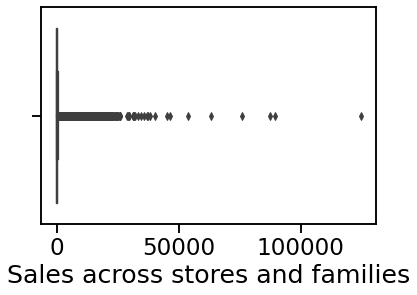

In [ ]:
sns.boxplot(x=train_extended['sales']).set_xlabel("Sales across stores and families")

Values of sales vary across the product families, with expected
minimum of 0, and maximum well above median of 11

## city

In [ ]:
train_extended['city'].value_counts()

Quito            1000296
Guayaquil         444576
Santo Domingo     166716
Cuenca            166716
Latacunga         111144
Manta             111144
Machala           111144
Ambato            111144
Quevedo            55572
Esmeraldas         55572
Loja               55572
Libertad           55572
Playas             55572
Daule              55572
Babahoyo           55572
Cayambe            55572
Salinas            55572
Puyo               55572
Guaranda           55572
Ibarra             55572
Riobamba           55572
El Carmen          55572
Name: city, dtype: int64

<AxesSubplot:>

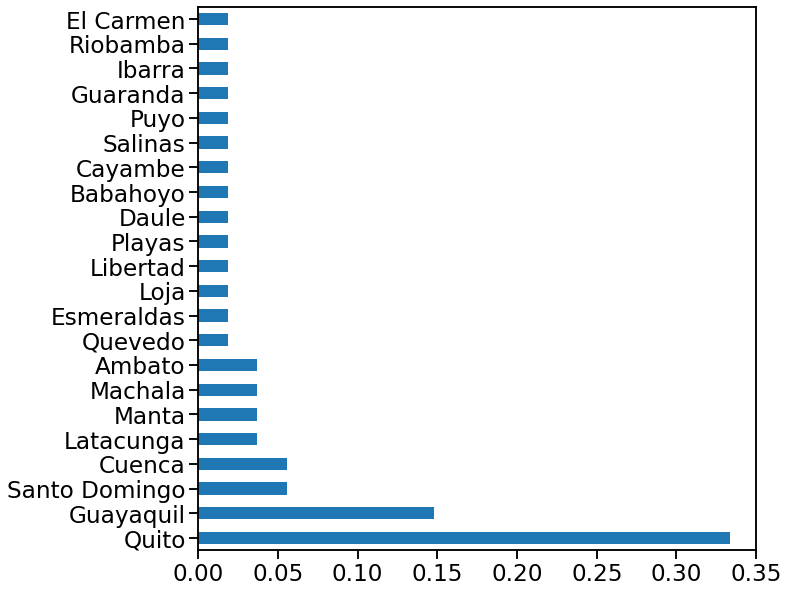

In [ ]:
train_extended['city'].value_counts(normalize=True).T.plot(kind='barh', figsize=(10,10))

Some cities have significant more stores, resulting in more product family entries.
Most stores are in the City Quito

## State

<AxesSubplot:>

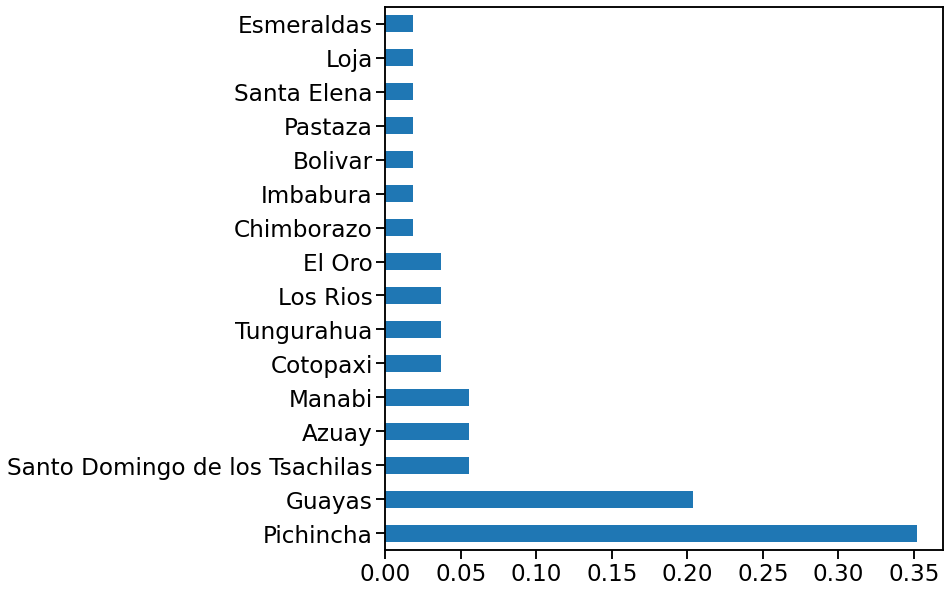

In [ ]:
train_extended['state'].value_counts(normalize=True).T.plot(kind='barh', figsize=(10,10))

Same states have more stores in their cityes resulting in more product families.

## type

In [ ]:
train_extended['type'].value_counts(normalize=True)

D    0.333333
C    0.277778
A    0.166667
B    0.148148
E    0.074074
Name: type, dtype: float64

Stores of type D are most common with 33%, un-even distribution of stores.

## transactions

Around 1300 transactions per store per day with heavy tailed/skew to the
right. two additional minor peaks could be investigated.

In [360]:
train_extended['transactions'].describe()

count    2.755104e+06
mean     1.694602e+03
std      9.632810e+02
min      5.000000e+00
25%      1.046000e+03
50%      1.393000e+03
75%      2.079000e+03
max      8.359000e+03
Name: transactions, dtype: float64

<AxesSubplot:xlabel='transactions', ylabel='Count'>

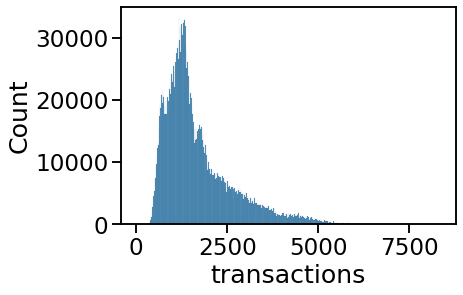

In [359]:
sns.histplot(train_extended['transactions'])

#  V. Multivariate Distribution  <a class="anchor" id="fifth-bullet"></a>

## STore Properties

* Most cities have just one store, but Guayaquil and Quito are outliers with 8 and 18!
This means most data is coming from these cities and might be less generalizable
to other cities or states in the dataset. **Bias**
* Store types are fairly distributed among cities and states

In [ ]:
val_count = lambda x: pd.value_counts(x).to_dict()

In [ ]:
stores.groupby(["state", "city"]).agg({"store_nbr": "count", "type": val_count})

store_nbr  \
state                          city                       
Azuay                          Cuenca                 3   
Bolivar                        Guaranda               1   
Chimborazo                     Riobamba               1   
Cotopaxi                       Latacunga              2   
El Oro                         Machala                2   
Esmeraldas                     Esmeraldas             1   
Guayas                         Daule                  1   
                               Guayaquil              8   
                               Libertad               1   
                               Playas                 1   
Imbabura                       Ibarra                 1   
Loja                           Loja                   1   
Los Rios                       Babahoyo               1   
                               Quevedo                1   
Manabi                         El Carmen              1   
                               Manta                  2   
Pastaza                        Puyo                   1   
Pichincha                      Cayambe                1   
                               Quito                 18   
Santa Elena                    Salinas                1   
Santo Domingo de los Tsachilas Santo Domingo          3   
Tungurahua                     Ambato                 2   

                                                                                  type  
state                          city                                                     
Azuay                          Cuenca                                 {'D': 2, 'B': 1}  
Bolivar                        Guaranda                                       {'C': 1}  
Chimborazo                     Riobamba                                       {'C': 1}  
Cotopaxi                       Latacunga                                      {'C': 2}  
El Oro                         Machala                                {'C': 1, 'D': 1}  
Esmeraldas                     Esmeraldas                                     {'E': 1}  
Guayas                         Daule                                          {'D': 1}  
                               Guayaquil      {'D': 2, 'E': 2, 'C': 2, 'B': 1, 'A': 1}  
                               Libertad                                       {'E': 1}  
                               Playas                                         {'C': 1}  
Imbabura                       Ibarra                                         {'C': 1}  
Loja                           Loja                                           {'D': 1}  
Los Rios                       Babahoyo                                       {'B': 1}  
                               Quevedo                                        {'C': 1}  
Manabi                         El Carmen                                      {'C': 1}  
                               Manta                                  {'A': 1, 'D': 1}  
Pastaza                        Puyo                                           {'C': 1}  
Pichincha                      Cayambe                                        {'B': 1}  
                               Quito                  {'D': 7, 'A': 6, 'B': 3, 'C': 2}  
Santa Elena                    Salinas                                        {'D': 1}  
Santo Domingo de los Tsachilas Santo Domingo                  {'D': 1, 'C': 1, 'B': 1}  
Tungurahua                     Ambato                                 {'D': 1, 'A': 1}

In [ ]:
stores.groupby(["state"]).count()['city']

state
Azuay                              3
Bolivar                            1
Chimborazo                         1
Cotopaxi                           2
El Oro                             2
Esmeraldas                         1
Guayas                            11
Imbabura                           1
Loja                               1
Los Rios                           2
Manabi                             3
Pastaza                            1
Pichincha                         19
Santa Elena                        1
Santo Domingo de los Tsachilas     3
Tungurahua                         2
Name: city, dtype: int64

### Store out-of-domain check

Are there stores in test set which are not in the train set. Potentially
out-of-domain (OOD)? 
> confirmed that each store has at least some training data available in
train AND in test

In [479]:
test['store_nbr'].isin(train_extended['store_nbr'].unique()).all()

True

In [481]:
train_extended['store_nbr'].isin(test['store_nbr'].unique()).all()

True

### When did stores start selling?

In [490]:
def first_sale_by_shop(df):
    df_sales = df[df['sales']>0]
    return df_sales['date'].min()

train_extended.groupby("store_nbr").apply(first_sale_by_shop).to_frame("date").sort_values("date")


,date
store_nbr,
25,2013-01-01
1,2013-01-02
34,2013-01-02
35,2013-01-02
37,2013-01-02
38,2013-01-02
39,2013-01-02
4,2013-01-02
40,2013-01-02


> Did not all start a the same time. Data is not avialalbe for all stores equally.
A few stores start selling products later in 2013, or even 2014, 2015 and 2017. 
For these stores less data will be available for predictions

In [515]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)


train_extended.groupby(["store_nbr", "family"]).apply(first_sale_by_shop).to_frame().reset_index(1).pivot(columns="family")

0                                                           \
family    AUTOMOTIVE  BABY CARE     BEAUTY  BEVERAGES      BOOKS BREAD/BAKERY   
store_nbr                                                                       
1         2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-13   2013-01-02   
10        2013-01-02 2014-07-01 2013-01-02 2013-01-02        NaT   2013-01-02   
11        2013-01-02 2014-03-19 2013-01-02 2013-01-02        NaT   2013-01-02   
12        2013-01-02 2016-02-10 2013-01-02 2013-01-02        NaT   2013-01-02   
13        2013-01-02        NaT 2013-01-02 2013-01-02        NaT   2013-01-02   
14        2013-01-02 2016-05-08 2013-01-02 2013-01-02        NaT   2013-01-02   
15        2013-01-02 2014-07-01 2013-01-02 2013-01-02        NaT   2013-01-02   
16        2013-01-02 2014-10-09 2013-01-03 2013-01-02        NaT   2013-01-02   
17        2013-01-02 2015-09-08 2013-01-02 2013-01-02        NaT   2013-01-02   
18        2013-01-02 2014-03-01 2013-01-02 2013-01-02        NaT   2013-01-02   
19        2013-01-02 2015-07-23 2013-01-02 2013-01-02        NaT   2013-01-02   
2         2013-01-02 2016-07-16 2013-01-02 2013-01-02 2016-10-13   2013-01-02   
20        2015-02-13 2015-06-17 2015-02-13 2015-02-13        NaT   2015-02-13   
21        2015-07-24 2015-12-06 2015-07-24 2015-07-24        NaT   2015-07-24   
22        2015-10-09 2016-01-20 2015-10-09 2015-10-09        NaT   2015-10-09   
23        2013-01-02        NaT 2013-01-03 2013-01-02 2016-10-12   2013-01-02   
24        2013-01-02 2016-07-20 2013-01-05 2013-01-02 2016-10-12   2013-01-02   
25        2013-01-03 2016-10-27 2013-01-01 2013-01-01 2016-10-27   2013-01-01   
26        2013-01-02 2016-07-15 2013-01-02 2013-01-02 2016-10-30   2013-01-02   
27        2013-01-02 2016-08-12 2013-01-02 2013-01-02 2016-10-14   2013-01-02   
28        2013-01-02 2016-11-07 2013-01-02 2013-01-02        NaT   2013-01-02   
29        2015-03-20 2015-06-03 2015-03-20 2015-03-20        NaT   2015-03-20   
3         2013-01-02 2016-07-16 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
30        2013-01-02 2014-03-01 2013-01-02 2013-01-02        NaT   2013-01-02   
31        2013-01-02 2014-07-12 2013-01-02 2013-01-02        NaT   2013-01-02   
32        2013-01-02 2014-03-19 2013-01-02 2013-01-02        NaT   2013-01-02   
33        2013-01-02 2015-12-16 2013-01-02 2013-01-02        NaT   2013-01-02   
34        2013-01-02 2014-03-01 2013-01-02 2013-01-02        NaT   2013-01-02   
35        2013-01-02 2014-09-03 2013-01-04 2013-01-02        NaT   2013-01-02   
36        2013-05-09 2015-12-22 2013-05-09 2013-05-09        NaT   2013-05-09   
37        2013-01-02 2016-12-10 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
38        2013-01-02 2016-07-15 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
39        2013-01-02 2014-03-01 2013-01-02 2013-01-02        NaT   2013-01-02   
4         2013-01-02 2016-12-05 2013-01-02 2013-01-02 2016-10-11   2013-01-02   
40        2013-01-02 2014-03-03 2013-01-02 2013-01-02        NaT   2013-01-02   
41        2013-01-02 2016-08-31 2013-01-02 2013-01-02 2016-10-20   2013-01-02   
42        2015-08-21 2016-08-14 2015-08-21 2015-08-21 2016-10-12   2015-08-21   
43        2013-01-02 2014-07-29 2013-01-02 2013-01-02        NaT   2013-01-02   
44        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
45        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-08   2013-01-02   
46        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-13   2013-01-02   
47        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
48        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
49        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
5         2013-01-02 2016-09-03 2013-01-02 2013-01-02 2016-10-12   2013-01-02   
50        2013-01-02        NaT 2013-01-02 2013-01-02 2016-10-11   2013-01-02   
51        2013-01-02        NaT 2013-01-02 2013-01

* BOOKS are not sold at many stores, no values for that feature in those cases.

## Sales over Time

### Overall

In [379]:
sales_by_year = train_extended.groupby(pd.Grouper(key="date", freq='Y')).sum()['sales'].to_frame("counts").reset_index()
sales_by_month = train_extended.groupby(pd.Grouper(key="date", freq='M')).sum()['sales'].to_frame("counts").reset_index()
sales_by_day = train_extended.groupby(pd.Grouper(key="date", freq='D')).sum()['sales'].to_frame("counts").reset_index()

In [381]:
fig = make_subplots(rows=3, cols=2, vertical_spacing=0.05, horizontal_spacing=0.05)
fig.add_trace(px.line(sales_by_year, x='date', y='counts', title='Line Items by Year').data[0], row=1, col=1)
fig.add_trace(px.line(sales_by_month, x='date', y='counts', title='Line Items by Year').data[0], row=2, col=1)
fig.add_trace(px.line(sales_by_day, x='date', y='counts', title='Line Items by Year').data[0], row=3, col=1)
fig.update_layout(height=600, width=1600, title_text="Total Sales by year, month, day")
fig



* Overall upwards trend in sales, drop in 2017 due to only half-year of data
* Strong drop in last day of data, maybe last day not fully recorded
* Dec 31, Jan1 0 sales, shops might be closed

In [388]:
sales_by_month['month'] = sales_by_month['date'].dt.month
sales_by_month['year'] = sales_by_month['date'].dt.year
px.line(sales_by_month, x='month', y='counts', title='Seasonal Pattern for Sales', color='year', markers=True)

* Overall sales have slighly pronounced seasonal patterns, mostly increase through year
* largest sales in winter, 12


### By Product Family

In [386]:
sales_monthly_family = train_extended.groupby(['family' ,pd.Grouper(key="date", freq='M')]).sum()['sales'].to_frame("counts").reset_index()

In [438]:
sales_monthly_family['month'] = sales_monthly_family['date'].dt.month
sales_monthly_family['year'] = sales_monthly_family['date'].dt.year

fig = px.line(sales_monthly_family, x='month', y='counts', title='Seasonal Patterns by Family', color='year', 
        facet_col='family', facet_col_wrap=3, markers=True, height=2000,
        facet_row_spacing=0.01, facet_col_spacing=0)
fig.update_yaxes(matches=None)
fig

* some families show increasing trend towards winter/december, some extremely
increase towards winter, e.g. "liquor, beer, wine" family, "frozen foods"
* "School and office supplieds" family peaks around september due to start of school (only 2014 introduced category)
* again we see that 2017/08, last month of data, is often times not representative of previous years (problem with data?)
* some categories show zig-zag behavior such as family "Produce".

In [436]:
sales_monthly_family['month'] = sales_monthly_family['date'].dt.month
sales_monthly_family['year'] = sales_monthly_family['date'].dt.year

fig = px.line(sales_monthly_family, x='date', y='counts', title='Total Sales by Family',
        facet_col='family', facet_col_wrap=3, markers=True, height=2000,
        facet_row_spacing=0.01, facet_col_spacing=0)
fig.update_yaxes(matches=None)
fig

* some products show that they were introduced at some point, others 
were not available for time periods, e.g. family books

## Missing Transactions 

We have 8% transactions missing for  train.csv. What properties of missingnes?

In [ ]:
train_extended.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,2155.0


In [443]:
train_extended['transactions_na'] = train_extended['transactions'].isna()

In [445]:
train_extended.groupby("transactions_na").sum()['sales']

transactions_na
False    1.071263e+09
True     2.382034e+06
Name: sales, dtype: float64

In [451]:
train_extended.groupby("transactions_na").describe()[['sales', 'onpromotion']]

sales                                           \
                     count        mean          std  min  25%   50%   
transactions_na                                                       
False            2755104.0  388.828486  1142.828508  0.0  0.0  17.0   
True              245784.0    9.691574   234.503322  0.0  0.0   0.0   

                                       onpromotion                            \
                       75%         max       count      mean        std  min   
transactions_na                                                                
False            230.61299  124717.000   2755104.0  2.833035  12.724993  0.0   
True               0.00000   19988.629    245784.0  0.021633   0.729582  0.0   

                                       
                 25%  50%  75%    max  
transactions_na                        
False            0.0  0.0  0.0  741.0  
True             0.0  0.0  0.0   77.0

In [472]:
train_extended['sales_zero'] = train_extended['sales'].apply(lambda x: x ==0)

In [474]:
train_extended.pivot_table(index='sales_zero', values='transactions_na', aggfunc='count')

,transactions_na
sales_zero,
False,2061758
True,939130


> Hypothesis that transactions are NaN if the sales are missing, no recording, is
not fully correct, but clearly there are less cases of sales. Outcome of feature
transaction might depend on target variable. 

In [453]:
train_extended.groupby("transactions_na").describe(include=['object']).T

transactions_na        False        True
id        count      2755104      245784
          unique     2755104      245784
          top            561           0
          freq             1           1
store_nbr count      2755104      245784
          unique          54          54
          top             39          52
          freq         55374       51678
family    count      2755104      245784
          unique          33          33
          top     AUTOMOTIVE  AUTOMOTIVE
          freq         83488        7448
city      count      2755104      245784
          unique          22          22
          top          Quito       Manta
          freq        966702       68739
state     count      2755104      245784
          unique          16          16
          top      Pichincha      Manabi
          freq       1022010       69003
type      count      2755104      245784
          unique           5           5
          top              D           B
          freq        942249       61479
cluster   count      2755104      245784
          unique          17          17
          top              3           6
          freq        386628       57387

> Unclear reason for missing transaction values and it could be dangerous to
build a feature from it, if we don't know how/when missing values appear.